## Recommeder Model

In [1]:
#Use conda to install scikit-surprise with the below command
#conda install -c conda-forge scikit-surprise

#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#surprise imports
import surprise
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

## Load Data

In [2]:
#load in csv data
raw_df = pd.read_csv('../../raw/input_runners_2020.csv')
raw_df.head()

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency
0,0,5.165000,4.973678,1.000000,18 - 34,F,United States,October,4.0,0.225806
1,0,5.165000,4.973678,1.000000,18 - 34,F,United States,October,6.0,0.677419
2,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,5.0,0.700000
3,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,6.0,0.466667
4,0,3.703333,3.424430,0.666667,18 - 34,F,United States,November,8.0,0.233333


In [3]:
#convert pace to minutes
raw_df['prev_month_weekly_pace'] = 60/raw_df['prev_month_weekly_pace']
raw_df.head()

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency
0,0,5.165000,12.063507,1.000000,18 - 34,F,United States,October,4.0,0.225806
1,0,5.165000,12.063507,1.000000,18 - 34,F,United States,October,6.0,0.677419
2,0,3.703333,17.521165,0.666667,18 - 34,F,United States,November,5.0,0.700000
3,0,3.703333,17.521165,0.666667,18 - 34,F,United States,November,6.0,0.466667
4,0,3.703333,17.521165,0.666667,18 - 34,F,United States,November,8.0,0.233333


In [4]:
#set "users" to athlete id + month

#convert months to number
def mtn(x):
    months = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    a = x.strip()[:3].lower()
    try:
        ez = months[a]
        return ez
    except:
        raise ValueError('Not a month')
        
raw_df["current_month"] =  raw_df["current_month"].apply(lambda x:mtn(x)) 

#create user ID
raw_df["user_id"] = raw_df["athlete"].astype(str) + "." + raw_df["current_month"].astype(str)

In [5]:
raw_df.head()

,athlete,prev_month_weekly_km,prev_month_weekly_pace,prev_month_weekly_days_run,age_bucket,gender,country,current_month,run_distance_rounded,weekly_frequency,user_id
0,0,5.165000,12.063507,1.000000,18 - 34,F,United States,10,4.0,0.225806,0.10
1,0,5.165000,12.063507,1.000000,18 - 34,F,United States,10,6.0,0.677419,0.10
2,0,3.703333,17.521165,0.666667,18 - 34,F,United States,11,5.0,0.700000,0.11
3,0,3.703333,17.521165,0.666667,18 - 34,F,United States,11,6.0,0.466667,0.11
4,0,3.703333,17.521165,0.666667,18 - 34,F,United States,11,8.0,0.233333,0.11


## Input New User Info

### Key next steps:
 - Turn into callable functions
 - Build method to add/update data for existing user

In [6]:
#filter dataset based on targets
gender = "F"
weekly_target = 40
age_bucket = "18 - 34"
month = mtn("October")
number_of_days = 5
new_id = '000.0'

#cold start for new user. Assumes long run 2x distance other runs.
new_user_data = { 
    'user_id' : [new_id] * 2,
    'run_distance_rounded' : [round(weekly_target/6), round(weekly_target/3)],
    'weekly_frequency' : [number_of_days -1, 1]
                }
new_user_df = pd.DataFrame(new_user_data)
new_user_df

,user_id,run_distance_rounded,weekly_frequency
0,000.0,7,4
1,000.0,13,1


## Train Model Based on User Filters

### Key next steps:
 - Turn into callable functions

In [7]:
#define objects for Surprise. Must be in user, item, rating order
filtered_df = raw_df.loc[
    (raw_df['gender'] == gender) &
    (raw_df['age_bucket'] == age_bucket) &
    (raw_df['current_month'] == month) &
    (raw_df['prev_month_weekly_days_run'] > (number_of_days-1)) & 
    (raw_df['prev_month_weekly_days_run'] < (number_of_days+1)) &
    (raw_df['prev_month_weekly_km'] > weekly_target-5) &
    (raw_df['prev_month_weekly_km'] < weekly_target+5)
]

#append new user data

filtered_df = pd.concat([filtered_df,new_user_df])
    
data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

In [8]:
#train model with 3 fold cross validation
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5137  0.5862  0.5718  0.5572  0.0313  
MAE (testset)     0.3316  0.3912  0.3638  0.3622  0.0243  
Fit time          0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.51369813, 0.5861793 , 0.57184037]),
 'test_mae': array([0.33163813, 0.39119121, 0.36384217]),
 'fit_time': (0.0011937618255615234,
  0.0010886192321777344,
  0.0010433197021484375),
 'test_time': (0.0006151199340820312,
  0.0005688667297363281,
  0.0004820823669433594)}

In [9]:
#fit the model using the full dataset
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [10]:
#generate recommendations by generating a list of run distances based on the average expected run lenghy

def generate_run_ratings(user_id, weekly_target, number_of_days, long_run_multiple = 3):
    
    """
    Generates a list of run distances with ratings based on weekly target, 
    number of days run each week, with an optional param that sets the upper 
    bound long run distance
    """
    
    #create list of run lengths
    run_list = range(round(weekly_target/(number_of_days+(long_run_multiple-1))), round((weekly_target/number_of_days) * long_run_multiple))
    results_dict = {'run_distance': [],
                   'run_rating': []}
    
    
    for run in run_list:
        rating_prediction = svd.predict(uid = user_id, iid = run)[3]
        results_dict['run_distance'].append(run)
        results_dict['run_rating'].append(rating_prediction)
        
    return pd.DataFrame(results_dict)


predictions = generate_run_ratings(new_id, weekly_target, number_of_days)

In [11]:
#sorted recommendations
predictions.sort_values(by=['run_rating'], ascending = False)

,run_distance,run_rating
1,7,1.316621
4,10,1.084361
2,8,1.010120
5,11,0.732356
7,13,0.700467
0,6,0.699341
3,9,0.668864
16,22,0.661736
14,20,0.660116
15,21,0.619122


## Model Evaluation

In [12]:
import time
import seaborn as sns

In [45]:
#build function to run simulations

def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_df.loc[
            (raw_df['gender'] == gender) &
            (raw_df['age_bucket'] == age_bucket) &
            (raw_df['prev_month_weekly_days_run'] >= (4)) & 
            (raw_df['prev_month_weekly_days_run'] <= (7)) &
            (raw_df['prev_month_weekly_km'] >= target_kms-1) &
            (raw_df['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= min_num_athletes:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        svd = SVD(verbose=False, n_epochs=10)
        validation = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

df1 = model_RMSE("F","18 - 34",10,100)
df2 = model_RMSE("M","18 - 34",10,100)
df3 = model_RMSE("F","35 - 54",10,100)
df4 = model_RMSE("M","35 - 54",10,100)
df5 = model_RMSE("F","55 +",10,100)
df6 = model_RMSE("M","55 +",10,100)

Finished in: 16.500656127929688
Finished in: 17.419121265411377
Finished in: 16.672704219818115
Finished in: 19.761464834213257
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 15.165188074111938
insufficient data for M 55 + 10
Finished in: 14.755286693572998


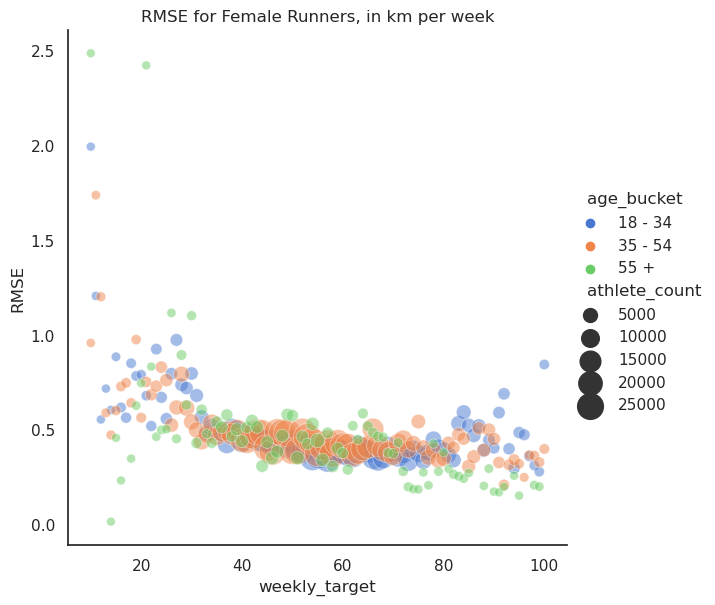

In [46]:
#combine datasets and graph
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

sns.set_theme(style="white")

sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "F"]
).set(title="RMSE for Female Runners, in km per week")

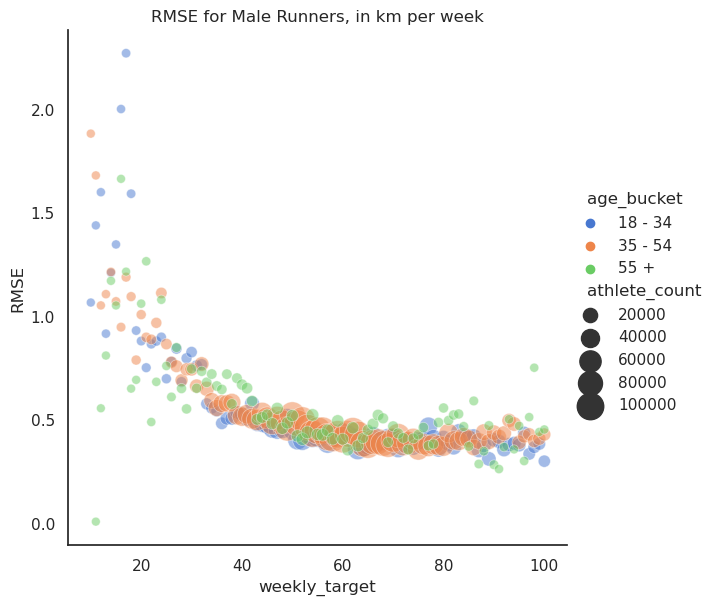

In [47]:
sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "M"]
).set(title="RMSE for Male Runners, in km per week")

### Weighted RMSE

For use to compare overall model performance

In [48]:
#calc weighted average RMSE for each set
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])
graph_df["RMSE_weight"] = graph_df["RMSE"]*graph_df["athlete_count"] 
df_SVD = graph_df.groupby(['age_bucket','gender']).agg({'RMSE_weight':'sum','athlete_count':'sum'})
df_SVD["Weighted_RMSE"] = df_SVD["RMSE_weight"]/df_SVD["athlete_count"]

In [49]:
df_SVD

RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.840759e+05         899041       0.427206
           M       1.025319e+06        2362558       0.433987
35 - 54    F       4.706491e+05        1055890       0.445737
           M       1.959967e+06        4303695       0.455415
55 +       F       5.968653e+04         131450       0.454063
           M       2.406179e+05         481613       0.499608

### Baseline KNN

In [38]:
from surprise.prediction_algorithms.knns import KNNBasic

In [39]:
#build function to run simulations

def model_RMSE(gender, age_bucket, start_km, end_km, min_num_athletes=10):
    """
    Function to evaluate SDV model, incrementing by 1km through km range for specific age group and gender
    """
    
    #Create empty dict for results
    results_dict = {
        'age_bucket': [],
        'gender': [],
        'weekly_target': [],
        'RMSE': [],
        'athlete_count': []
    }

    start = time.time()
    
    for target_kms in range(start_km, end_km+1): 

        #define objects for Surprise. Must be in user, item, rating order
        filtered_df = raw_df.loc[
            (raw_df['gender'] == gender) &
            (raw_df['age_bucket'] == age_bucket) &
            (raw_df['prev_month_weekly_days_run'] >= (4)) & 
            (raw_df['prev_month_weekly_days_run'] <= (7)) &
            (raw_df['prev_month_weekly_km'] >= target_kms-1) &
            (raw_df['prev_month_weekly_km'] <= target_kms+1)
        ]
        
        athlete_count = filtered_df.size
        
        if filtered_df.size <= min_num_athletes:
            print("insufficient data for",gender,age_bucket,target_kms)
            continue 

        #convert datates    
        data = Dataset.load_from_df(filtered_df[["user_id","run_distance_rounded","weekly_frequency"]], Reader(rating_scale=(0,7)))

        #build model
        knn = KNNBasic(verbose=False)
        validation = cross_validate(knn, data, measures=['RMSE'], cv=3, verbose=False)

        #capture outputs for dict from final fold
        results_dict['gender'].append(gender)
        results_dict['age_bucket'].append(age_bucket)
        results_dict['weekly_target'].append(target_kms)
        results_dict['RMSE'].append(validation['test_rmse'][2])
        results_dict['athlete_count'].append(athlete_count)
        
        #clean up memory
        del filtered_df

    end = time.time()
        
    print("Finished in:", end - start)
    
    return pd.DataFrame(results_dict)

df1 = model_RMSE("F","18 - 34",10,100)
df2 = model_RMSE("M","18 - 34",10,100)
df3 = model_RMSE("F","35 - 54",10,100)
df4 = model_RMSE("M","35 - 54",10,100)
df5 = model_RMSE("F","55 +",10,100)
df6 = model_RMSE("M","55 +",10,100)

Finished in: 17.878889322280884
Finished in: 26.001344680786133
Finished in: 18.76625108718872
Finished in: 47.189549684524536
insufficient data for F 55 + 11
insufficient data for F 55 + 12
insufficient data for F 55 + 13
insufficient data for F 55 + 17
insufficient data for F 55 + 86
insufficient data for F 55 + 87
insufficient data for F 55 + 93
insufficient data for F 55 + 96
insufficient data for F 55 + 97
insufficient data for F 55 + 100
Finished in: 15.109002351760864
insufficient data for M 55 + 10
Finished in: 15.025612592697144


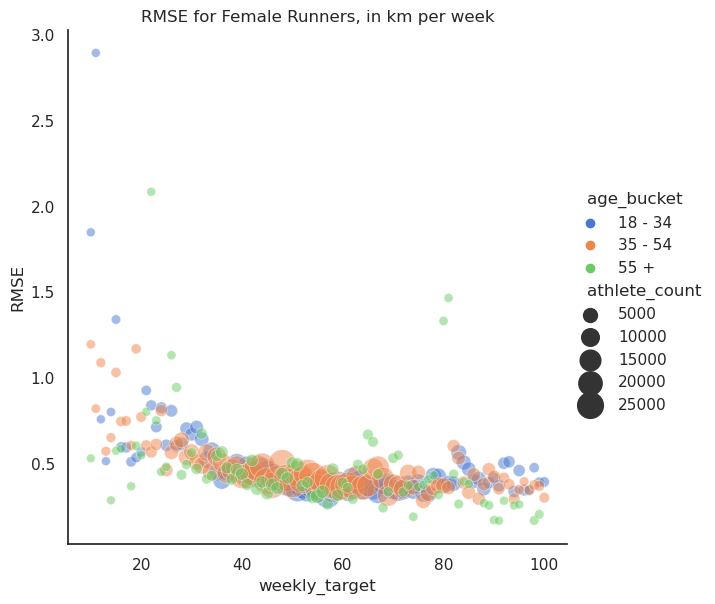

In [40]:
#combine datasets and graph
graph_df = pd.concat([df1,df2,df3,df4,df5,df6])

sns.set_theme(style="white")

sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "F"]
).set(title="RMSE for Female Runners, in km per week")

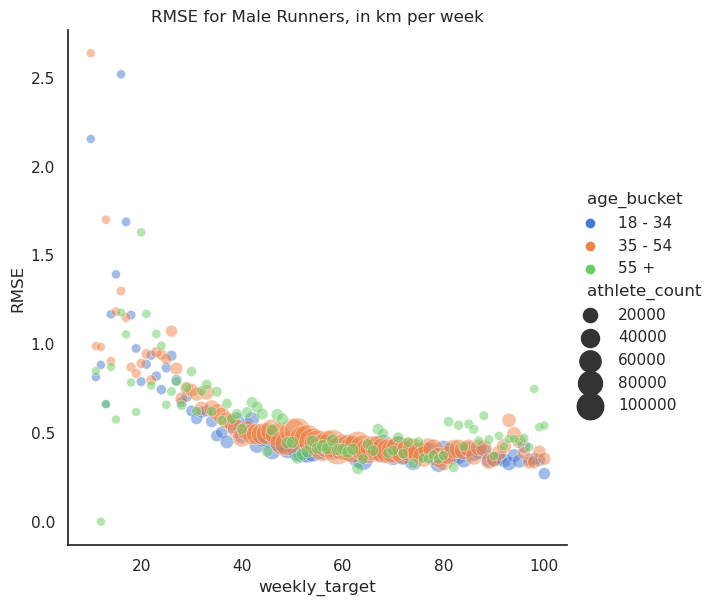

In [42]:
sns.relplot(
    x="weekly_target", 
    y="RMSE", 
    hue="age_bucket", 
    size="athlete_count",
    sizes=(40, 400), 
    alpha=.5, 
    palette="muted",
    height=6, 
    data=graph_df.loc[graph_df['gender'] == "M"]
).set(title="RMSE for Male Runners, in km per week")

In [44]:
#calc weighted average RMSE for each set
graph_df["RMSE_weight"] = graph_df["RMSE"]*graph_df["athlete_count"] 
df_KNN = graph_df.groupby(['age_bucket','gender']).agg({'RMSE_weight':'sum','athlete_count':'sum'})
df_KNN["Weighted_RMSE"] = df_KNN["RMSE_weight"]/df_KNN["athlete_count"]
df_KNN

RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.652337e+05         899041       0.406248
           M       9.871784e+05        2362558       0.417843
35 - 54    F       4.474256e+05        1055890       0.423743
           M       1.948426e+06        4303695       0.452733
55 +       F       5.577290e+04         131450       0.424290
           M       2.348877e+05         481613       0.487710

In [52]:
df_SVD

RMSE_weight  athlete_count  Weighted_RMSE
age_bucket gender                                            
18 - 34    F       3.840759e+05         899041       0.427206
           M       1.025319e+06        2362558       0.433987
35 - 54    F       4.706491e+05        1055890       0.445737
           M       1.959967e+06        4303695       0.455415
55 +       F       5.968653e+04         131450       0.454063
           M       2.406179e+05         481613       0.499608

In [51]:
#EOF